Read/Tidy results from PCA-SIFT Training

In [1]:
import pickle
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import os

In [2]:
dataset_dir = Path('dataset/icub_custom_subset')
cats = sorted([cat for cat in os.listdir(dataset_dir) if os.path.isdir(dataset_dir / cat)])
LABEL_TO_CAT = {i:cat for i, cat in enumerate(cats)}
CAT_TO_LABEL = {cat:i for i, cat in enumerate(cats)}
LABELS = cats
print(cats); print(); print()
print(LABEL_TO_CAT); print(); print()
print(CAT_TO_LABEL)

['bodylotion', 'book', 'cellphone', 'flower', 'glass', 'hairbrush', 'hairclip', 'mouse', 'mug', 'ovenglove', 'pencilcase', 'perfume', 'remote', 'ringbinder', 'soapdispenser', 'sodabottle', 'sprayer', 'squeezer', 'sunglasses', 'wallet']


{0: 'bodylotion', 1: 'book', 2: 'cellphone', 3: 'flower', 4: 'glass', 5: 'hairbrush', 6: 'hairclip', 7: 'mouse', 8: 'mug', 9: 'ovenglove', 10: 'pencilcase', 11: 'perfume', 12: 'remote', 13: 'ringbinder', 14: 'soapdispenser', 15: 'sodabottle', 16: 'sprayer', 17: 'squeezer', 18: 'sunglasses', 19: 'wallet'}


{'bodylotion': 0, 'book': 1, 'cellphone': 2, 'flower': 3, 'glass': 4, 'hairbrush': 5, 'hairclip': 6, 'mouse': 7, 'mug': 8, 'ovenglove': 9, 'pencilcase': 10, 'perfume': 11, 'remote': 12, 'ringbinder': 13, 'soapdispenser': 14, 'sodabottle': 15, 'sprayer': 16, 'squeezer': 17, 'sunglasses': 18, 'wallet': 19}


In [3]:
tdy = datetime(2025, 4, 26, 1, 6, 57)
top_model_dir = Path(f'models_icub/PCA-SIFT/{tdy.strftime("%Y%m%d-%H%M%S")}/')

if not top_model_dir.exists():
    raise FileNotFoundError(f"Directory {top_model_dir} does not exist.")

In [4]:
# go through all directories in the top_model_dir to build the hyperparameter grid for us
# assume there are KMeans and PCA N components as hyperparameters

def get_hyperparameter_grid(top_model_dir):
    hyperparameter_grid = []
    for model_dir in top_model_dir.iterdir():
        if not model_dir.is_dir():
            continue
        # get the KMeans n_clusters
        kmeans_n_clusters = int(model_dir.name.split('_')[1])
        # get the PCA N components
        pca_n_components = int(model_dir.name.split('_')[3])
        # add to the hyperparameter grid
        hyperparameter_grid.append((kmeans_n_clusters, pca_n_components))
    return hyperparameter_grid

hyperparameter_grid = sorted(get_hyperparameter_grid(top_model_dir))
hyperparameter_grid

[(20, 20),
 (20, 50),
 (20, 128),
 (40, 20),
 (40, 50),
 (40, 128),
 (80, 20),
 (80, 50),
 (80, 128),
 (160, 20),
 (160, 50),
 (160, 128),
 (320, 20),
 (320, 50),
 (320, 128),
 (640, 20),
 (640, 50),
 (640, 128)]

In [5]:
# create a dataframe to store the results
# we are interested in weighted acc of all models in test and evaluation sets
# and weighted F1 score on both sets

df_testset_dict = {'kmeans_n_clusters':[], 'pca_n_components':[], 'weighted_acc':[], 'weighted_f1':[]}
df_evalset_dict = {'kmeans_n_clusters': [], 'pca_n_components': [], 'weighted_acc':[], 'weighted_f1':[]}

In [6]:
# we loop through the hyperparameter grid
# visit the directory
# grab the y_test_ , y_pred_test, y_eval_, y_pred_eval_ numpy array files
# and load them
# then we calculate the weighted acc and f1 score

import numpy as np
from sklearn.metrics import classification_report, balanced_accuracy_score

def calculate_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    acc = report['accuracy']
    weighted_acc = balanced_accuracy_score(y_true, y_pred)
    weighted_f1 = report['weighted avg']['f1-score']
    return acc, weighted_acc, weighted_f1

for kmeans_n_clusters, pca_n_components in hyperparameter_grid:
    # visit the directory
    model_dir = top_model_dir / f'KMeans_{kmeans_n_clusters}_PCA_{pca_n_components}'
    if not model_dir.exists():
        continue
    # load the y_test_ , y_pred_test, y_eval_, y_pred_eval_ numpy array files
    y_test = np.load(model_dir / f'y_test_filtered.npy')
    y_pred_test = np.load(model_dir / f'y_pred_test.npy')
    y_eval = np.load(model_dir / f'y_val_filtered.npy')
    y_pred_eval = np.load(model_dir / f'y_pred_val.npy')

    # calculate the metrics
    acc_test, weighted_acc_test, weighted_f1_test = calculate_metrics(y_test, y_pred_test)
    acc_eval, weighted_acc_eval, weighted_f1_eval = calculate_metrics(y_eval, y_pred_eval)

    print('---' * 20)
    print(f'KMeans n_clusters: {kmeans_n_clusters}, PCA n_components: {pca_n_components}')
    print(f'Weighted Acc Test: {weighted_acc_test}, Weighted F1 Test: {weighted_f1_test}')
    print(f'Weighted Acc Eval: {weighted_acc_eval}, Weighted F1 Eval: {weighted_f1_eval}')
    print('---' * 20)
    # add to the dictionaries
    df_testset_dict['kmeans_n_clusters'].append(kmeans_n_clusters)
    df_testset_dict['pca_n_components'].append(pca_n_components)
    df_testset_dict['weighted_acc'].append(weighted_acc_test)
    df_testset_dict['weighted_f1'].append(weighted_f1_test)

    df_evalset_dict['kmeans_n_clusters'].append(kmeans_n_clusters)
    df_evalset_dict['pca_n_components'].append(pca_n_components)
    df_evalset_dict['weighted_acc'].append(weighted_acc_eval)
    df_evalset_dict['weighted_f1'].append(weighted_f1_eval)

# create the dataframes
df_testset = pd.DataFrame(df_testset_dict)
df_evalset = pd.DataFrame(df_evalset_dict)


------------------------------------------------------------
KMeans n_clusters: 20, PCA n_components: 20
Weighted Acc Test: 0.28384615384615386, Weighted F1 Test: 0.26739976600859094
Weighted Acc Eval: 0.28200000000000003, Weighted F1 Eval: 0.2665269649465164
------------------------------------------------------------
------------------------------------------------------------
KMeans n_clusters: 20, PCA n_components: 50
Weighted Acc Test: 0.2911538461538462, Weighted F1 Test: 0.274273937867217
Weighted Acc Eval: 0.27666666666666667, Weighted F1 Eval: 0.26010968456755124
------------------------------------------------------------
------------------------------------------------------------
KMeans n_clusters: 20, PCA n_components: 128
Weighted Acc Test: 0.28038461538461545, Weighted F1 Test: 0.26590049856913023
Weighted Acc Eval: 0.26966666666666667, Weighted F1 Eval: 0.25358925132079085
------------------------------------------------------------
-------------------------------------

In [7]:
df_testset

,kmeans_n_clusters,pca_n_components,weighted_acc,weighted_f1
0,20,20,0.283846,0.267400
1,20,50,0.291154,0.274274
2,20,128,0.280385,0.265900
3,40,20,0.339231,0.327704
4,40,50,0.344231,0.334492
5,40,128,0.350000,0.341165
6,80,20,0.370769,0.365057
7,80,50,0.369615,0.362864
8,80,128,0.367692,0.362683
9,160,20,0.361154,0.357582


In [8]:
df_evalset

,kmeans_n_clusters,pca_n_components,weighted_acc,weighted_f1
0,20,20,0.282000,0.266527
1,20,50,0.276667,0.260110
2,20,128,0.269667,0.253589
3,40,20,0.332667,0.322444
4,40,50,0.335000,0.327923
5,40,128,0.337333,0.327533
6,80,20,0.351667,0.346482
7,80,50,0.369667,0.361855
8,80,128,0.375000,0.369054
9,160,20,0.377000,0.372466


In [9]:
# sort the dataframes by weighted f1 score
df_testset.sort_values(by='weighted_f1', ascending=False)

,kmeans_n_clusters,pca_n_components,weighted_acc,weighted_f1
11,160,128,0.387308,0.384172
10,160,50,0.380769,0.377121
6,80,20,0.370769,0.365057
7,80,50,0.369615,0.362864
8,80,128,0.367692,0.362683
12,320,20,0.364615,0.360367
14,320,128,0.365769,0.359705
13,320,50,0.363462,0.358076
9,160,20,0.361154,0.357582
17,640,128,0.353462,0.349762


In [10]:
df_evalset.sort_values(by='weighted_f1', ascending=False)

,kmeans_n_clusters,pca_n_components,weighted_acc,weighted_f1
11,160,128,0.378333,0.373275
9,160,20,0.377000,0.372466
14,320,128,0.375000,0.371532
10,160,50,0.373667,0.369500
8,80,128,0.375000,0.369054
13,320,50,0.366000,0.362448
7,80,50,0.369667,0.361855
12,320,20,0.359667,0.355784
16,640,50,0.358000,0.355218
17,640,128,0.351667,0.348189


In [11]:
np.log(np.array(df_testset['kmeans_n_clusters'].unique(), dtype=int))

array([2.99573227, 3.68887945, 4.38202663, 5.07517382, 5.768321  ,
       6.46146818])

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot the results as multi-line plots

def plot_results(df, title, x, y, x_label, y_label):
    plt.figure(figsize=(12, 6), dpi=300)
    sns.lineplot(data=df, x=x, y=y, hue='pca_n_components', marker='o')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # apply log scale to the x axis
    plt.xscale('log', base=2)
    plt.xticks(df['kmeans_n_clusters'].unique(), labels=df['kmeans_n_clusters'].unique())
    plt.legend(title='PCA n_components')
    plt.grid()
    plt.show()

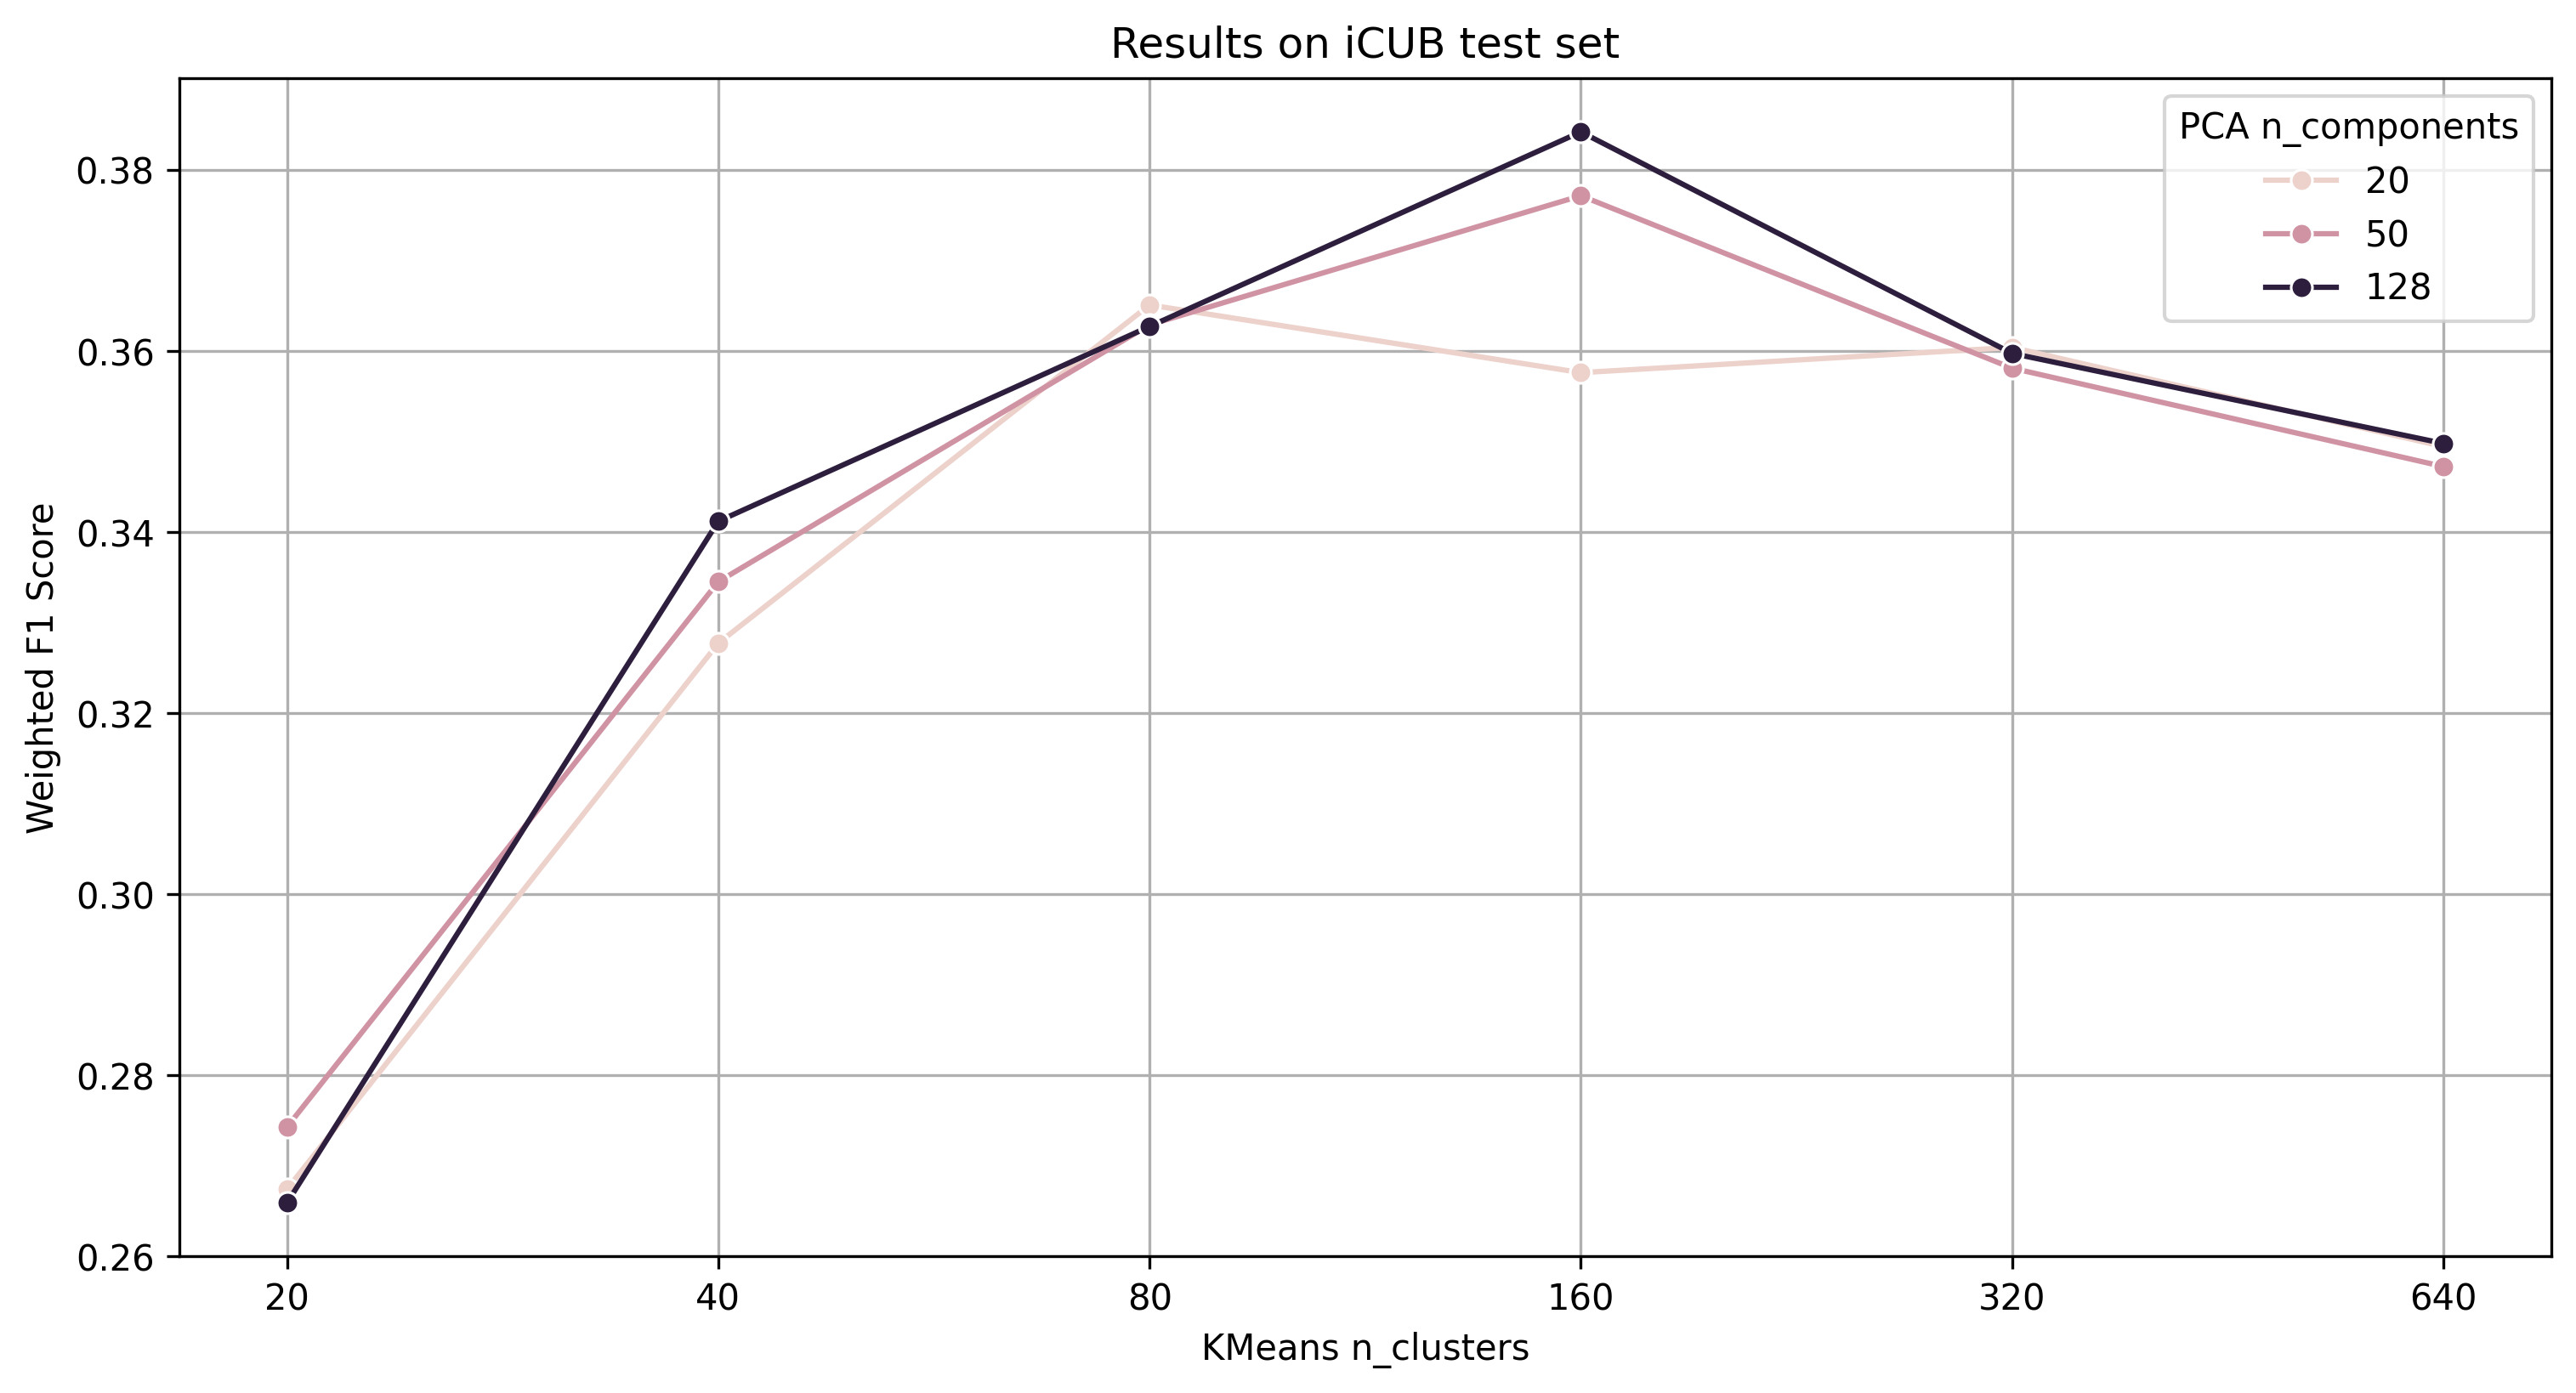

In [13]:
plot_results(df_testset, 'Results on iCUB test set', 'kmeans_n_clusters', 'weighted_f1', 'KMeans n_clusters', 'Weighted F1 Score')

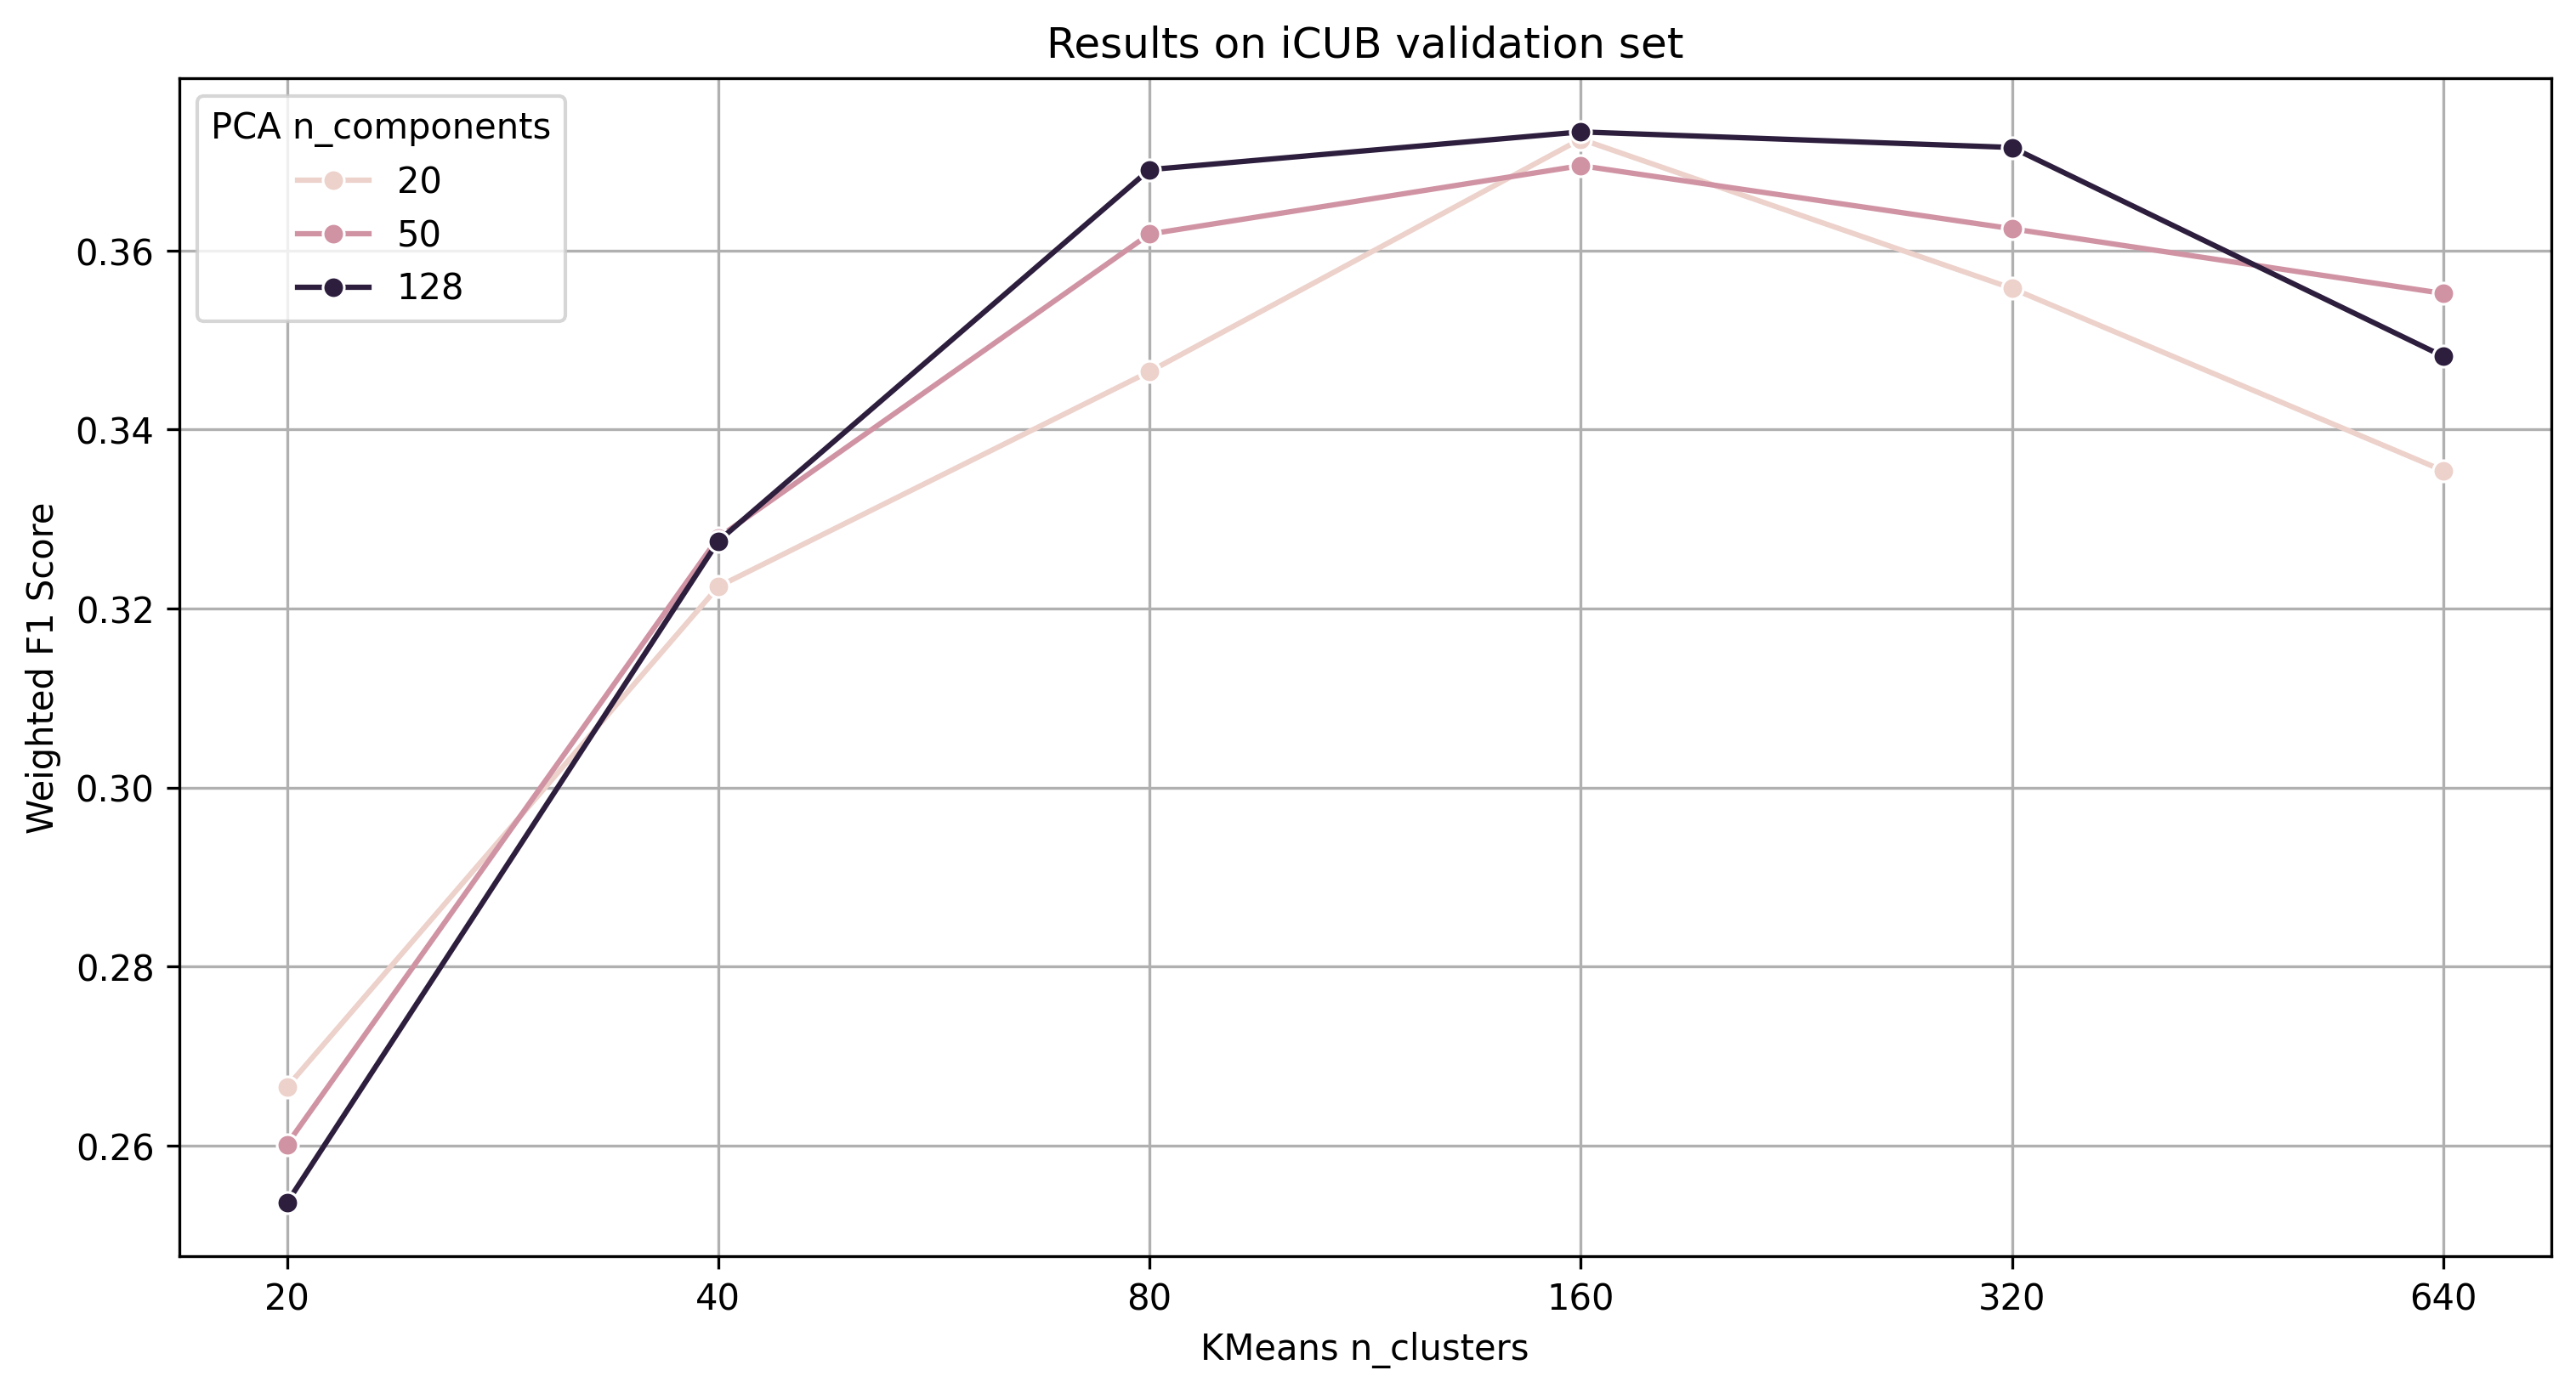

In [14]:
plot_results(df_evalset, 'Results on iCUB validation set', 'kmeans_n_clusters', 'weighted_f1', 'KMeans n_clusters', 'Weighted F1 Score')

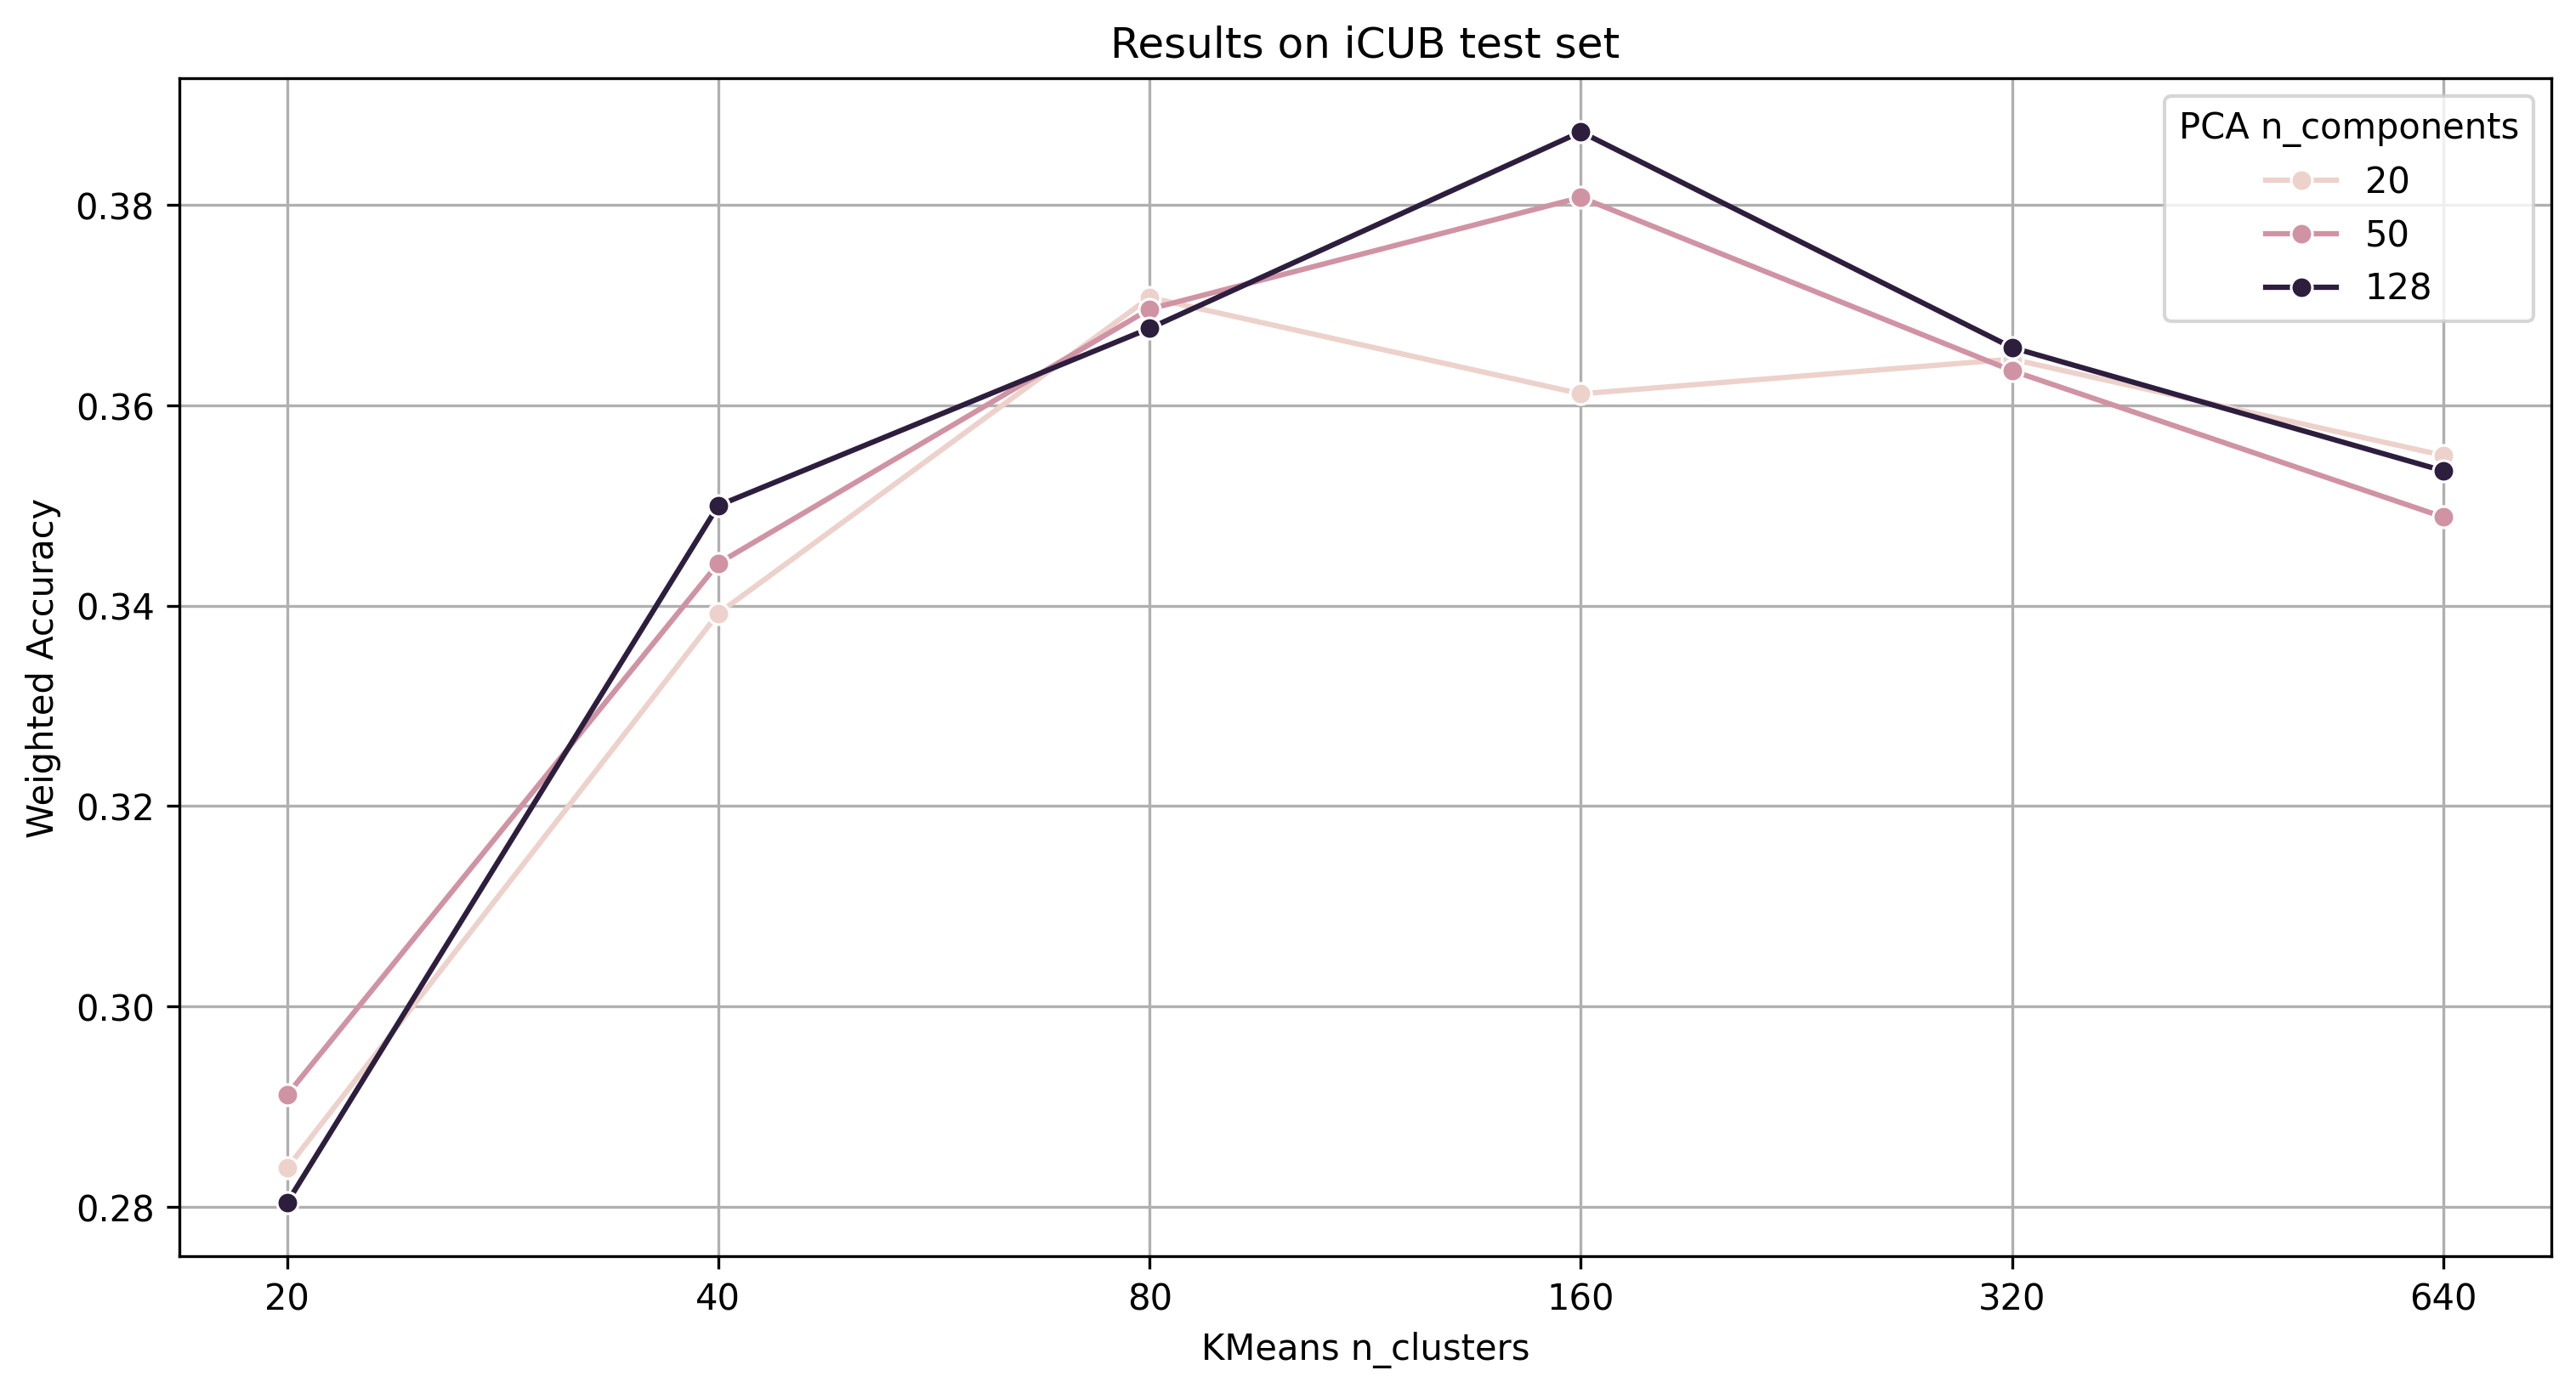

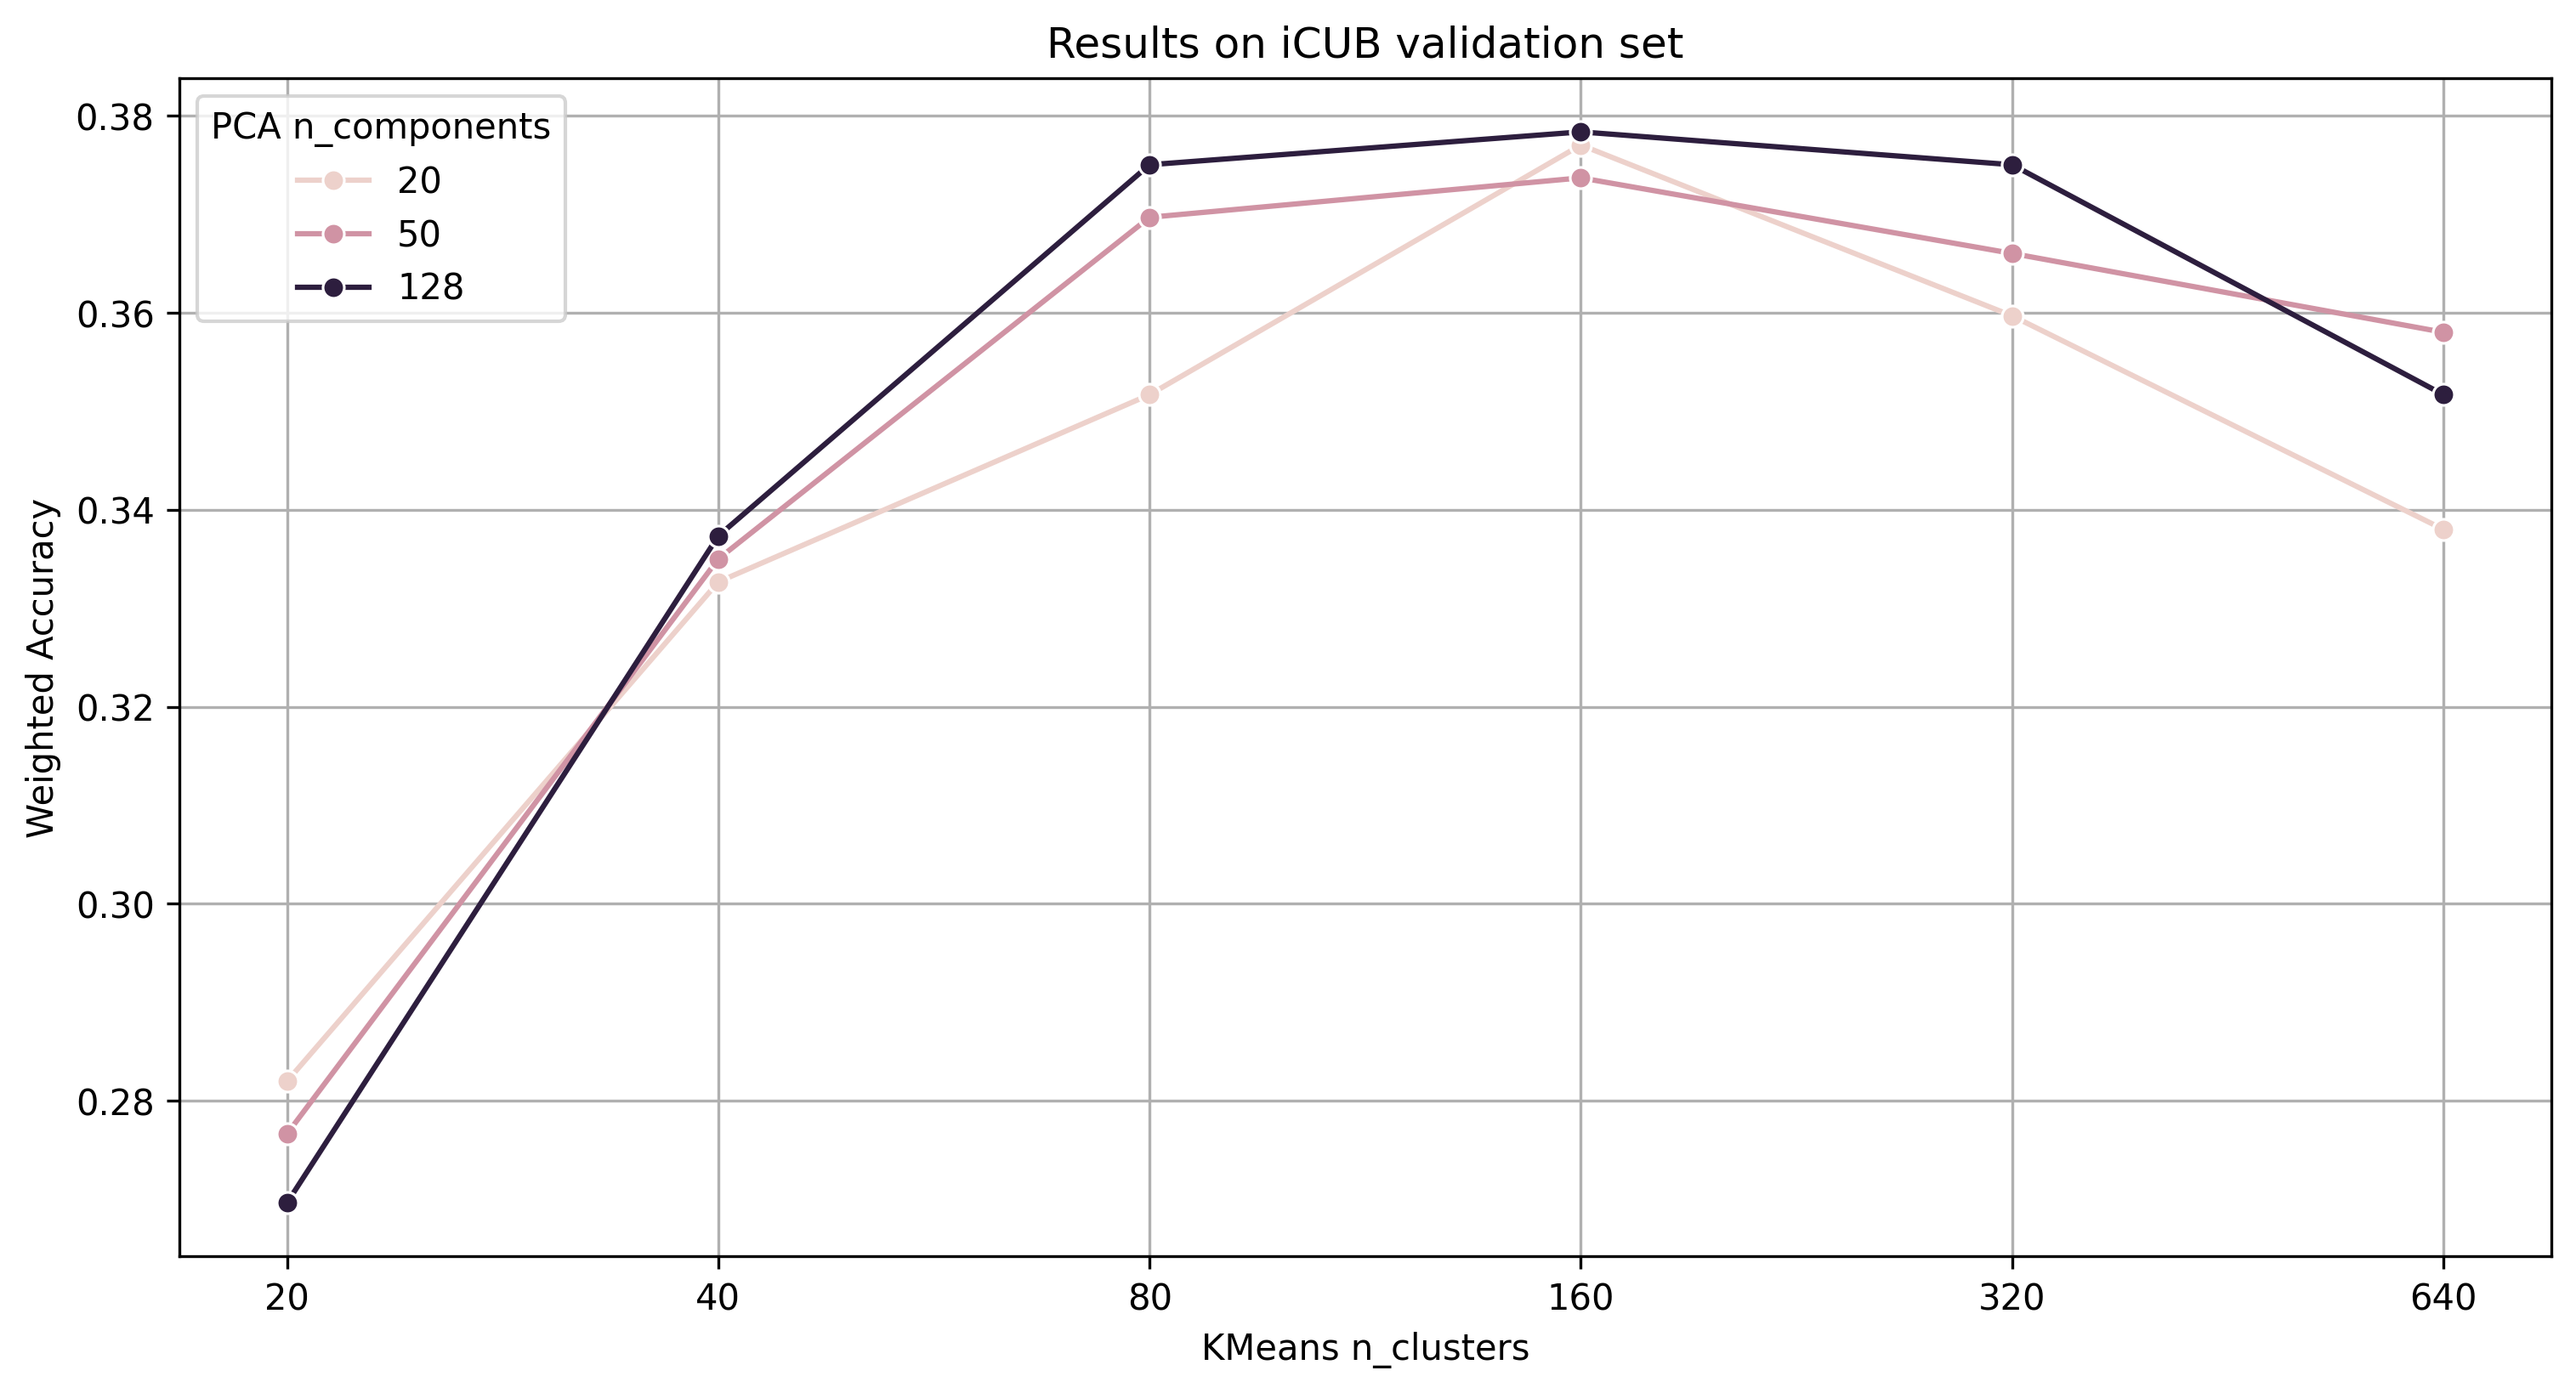

In [15]:
plot_results(df_testset, 'Results on iCUB test set', 'kmeans_n_clusters', 'weighted_acc', 'KMeans n_clusters', 'Weighted Accuracy')
plot_results(df_evalset, 'Results on iCUB validation set', 'kmeans_n_clusters', 'weighted_acc', 'KMeans n_clusters', 'Weighted Accuracy')

Select the best model and view its confusion matrix

In [16]:
best_model_eval = df_evalset.loc[df_evalset['weighted_f1'].idxmax()]
best_kmeans_n_clusters, best_pca_n_components = int(best_model_eval['kmeans_n_clusters']), int(best_model_eval['pca_n_components'])

model_dir = top_model_dir / f'KMeans_{best_kmeans_n_clusters}_PCA_{best_pca_n_components}'
if not model_dir.exists():
    raise FileNotFoundError(f"Directory {model_dir} does not exist.")

# load the y_test_ , y_pred_test, y_eval_, y_pred_eval_ numpy array files
y_test = np.load(model_dir / f'y_test_filtered.npy')
y_pred_test = np.load(model_dir / f'y_pred_test.npy')
y_eval = np.load(model_dir / f'y_val_filtered.npy')
y_pred_eval = np.load(model_dir / f'y_pred_val.npy')

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8),dpi=300)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Assuming you have a list of class names

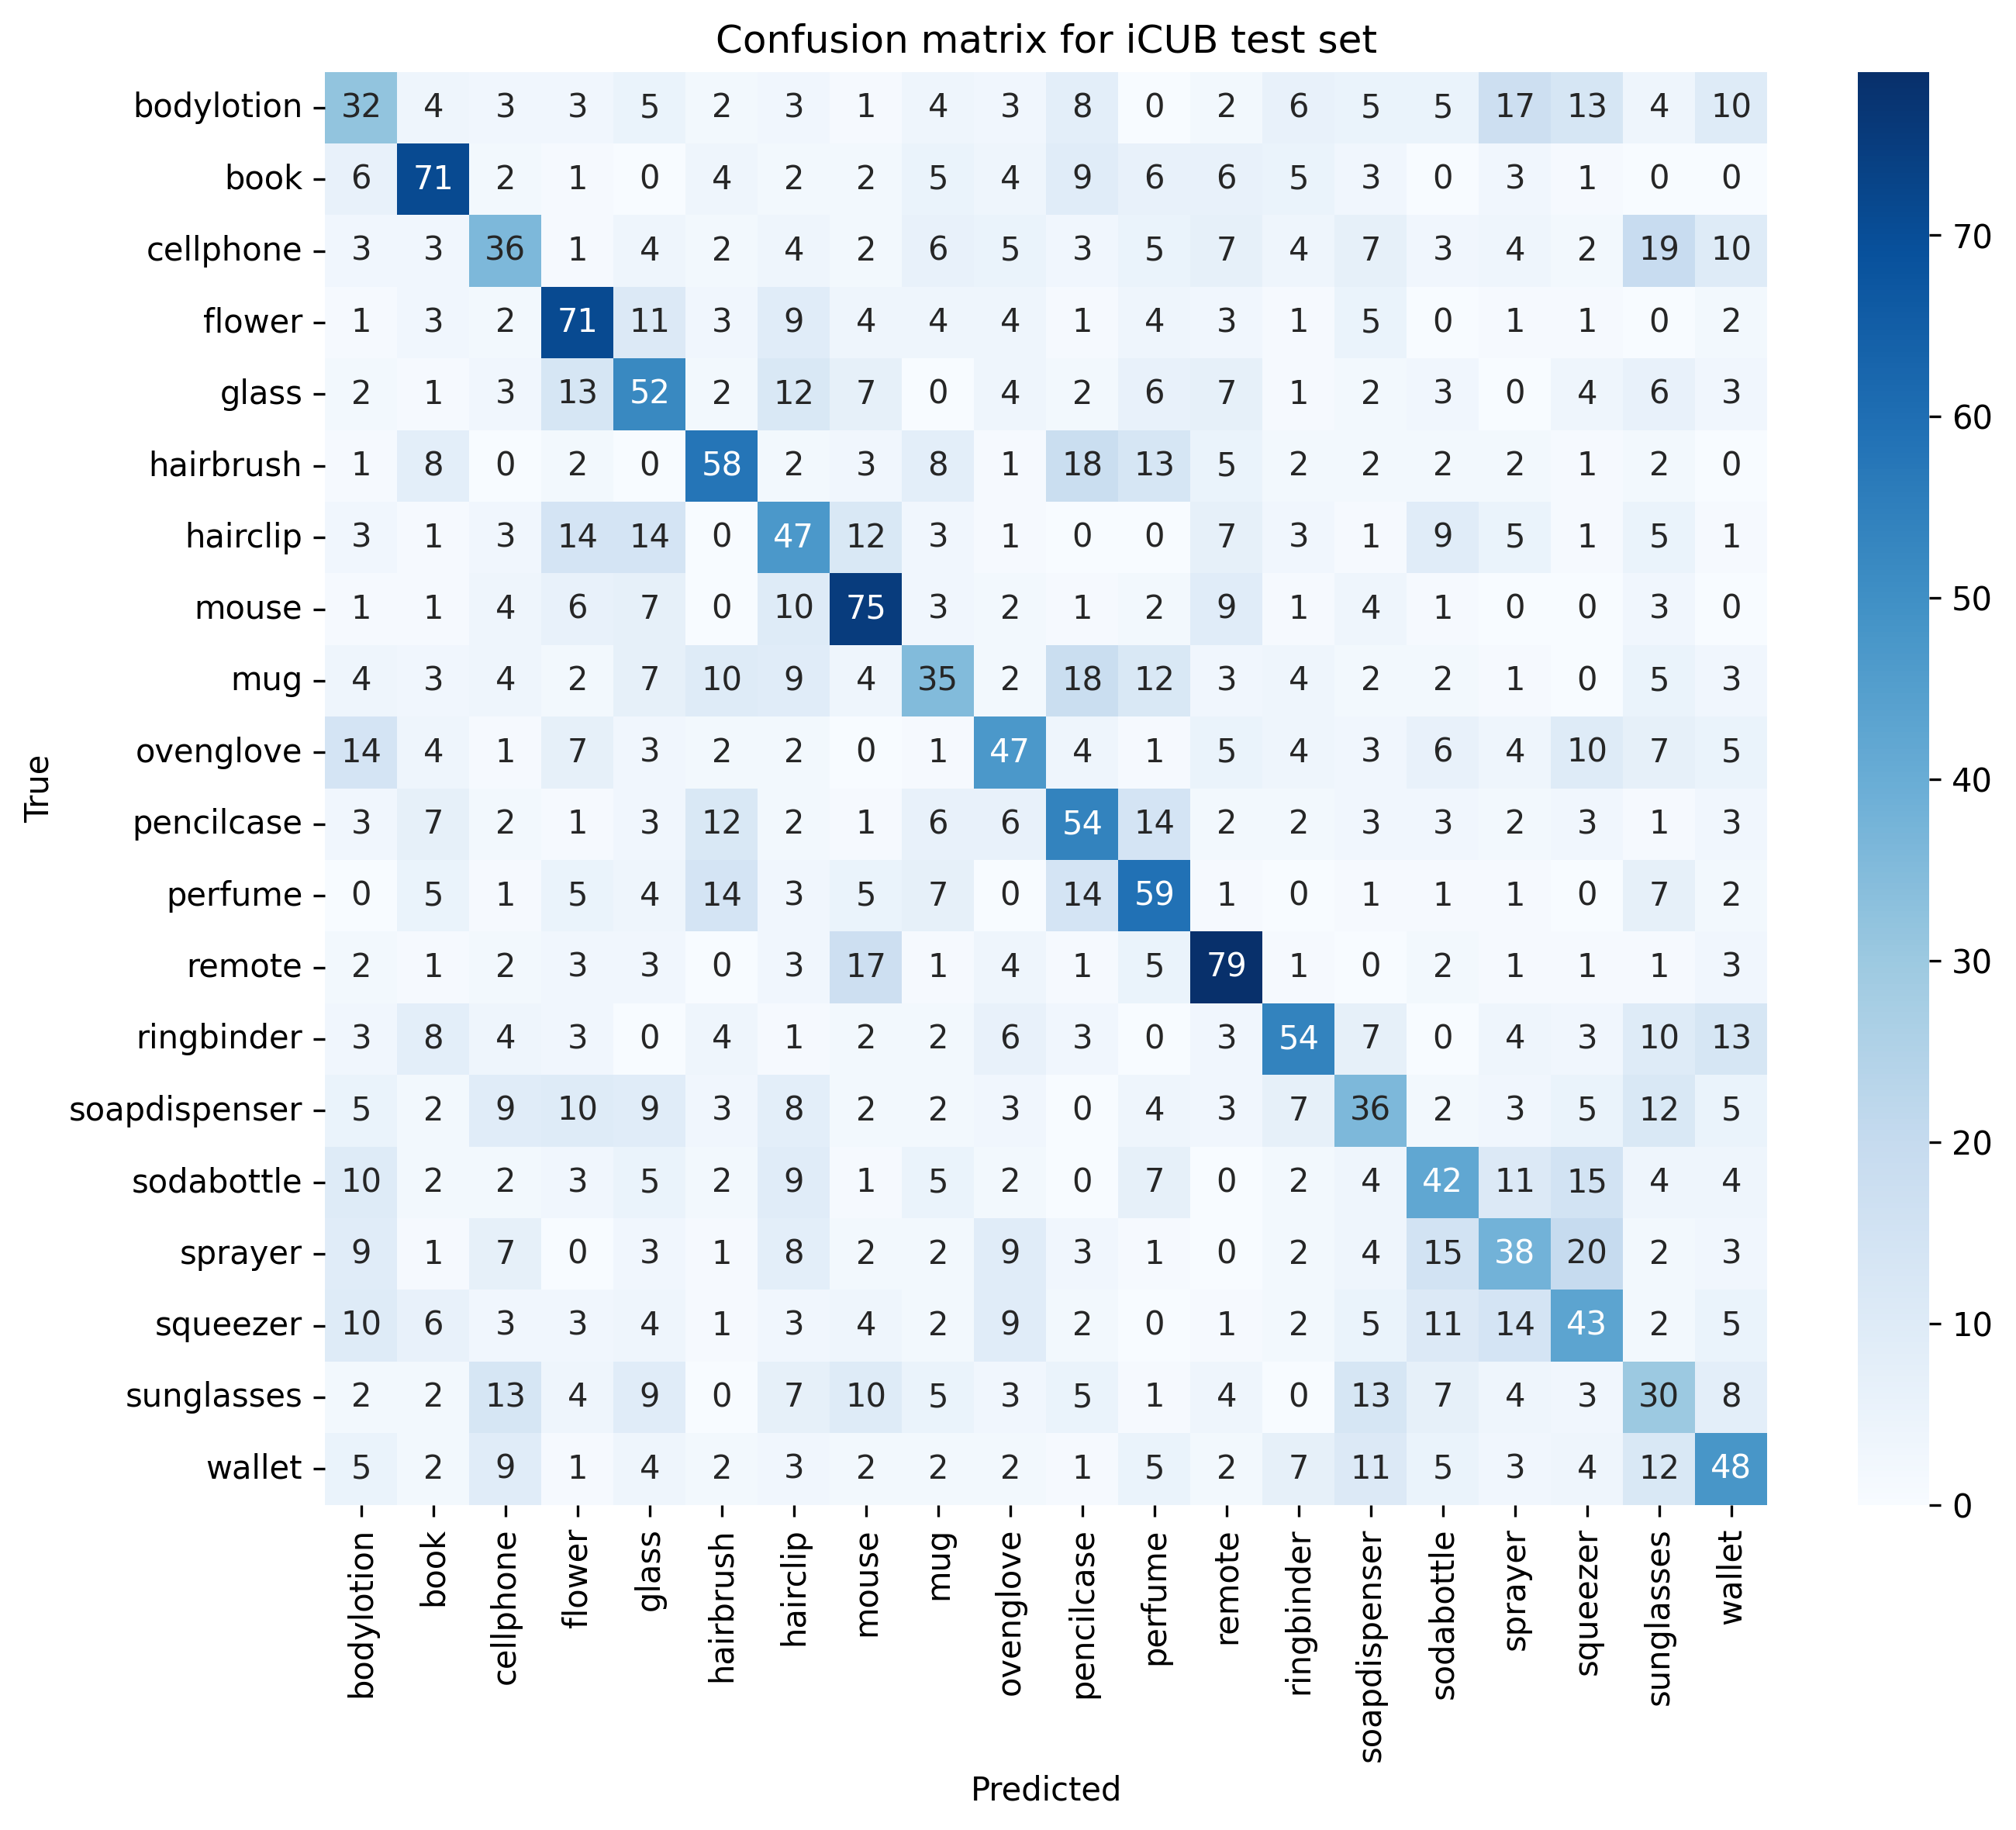

In [17]:
plot_confusion_matrix(y_test, y_pred_test, LABELS, 'Confusion matrix for iCUB test set')

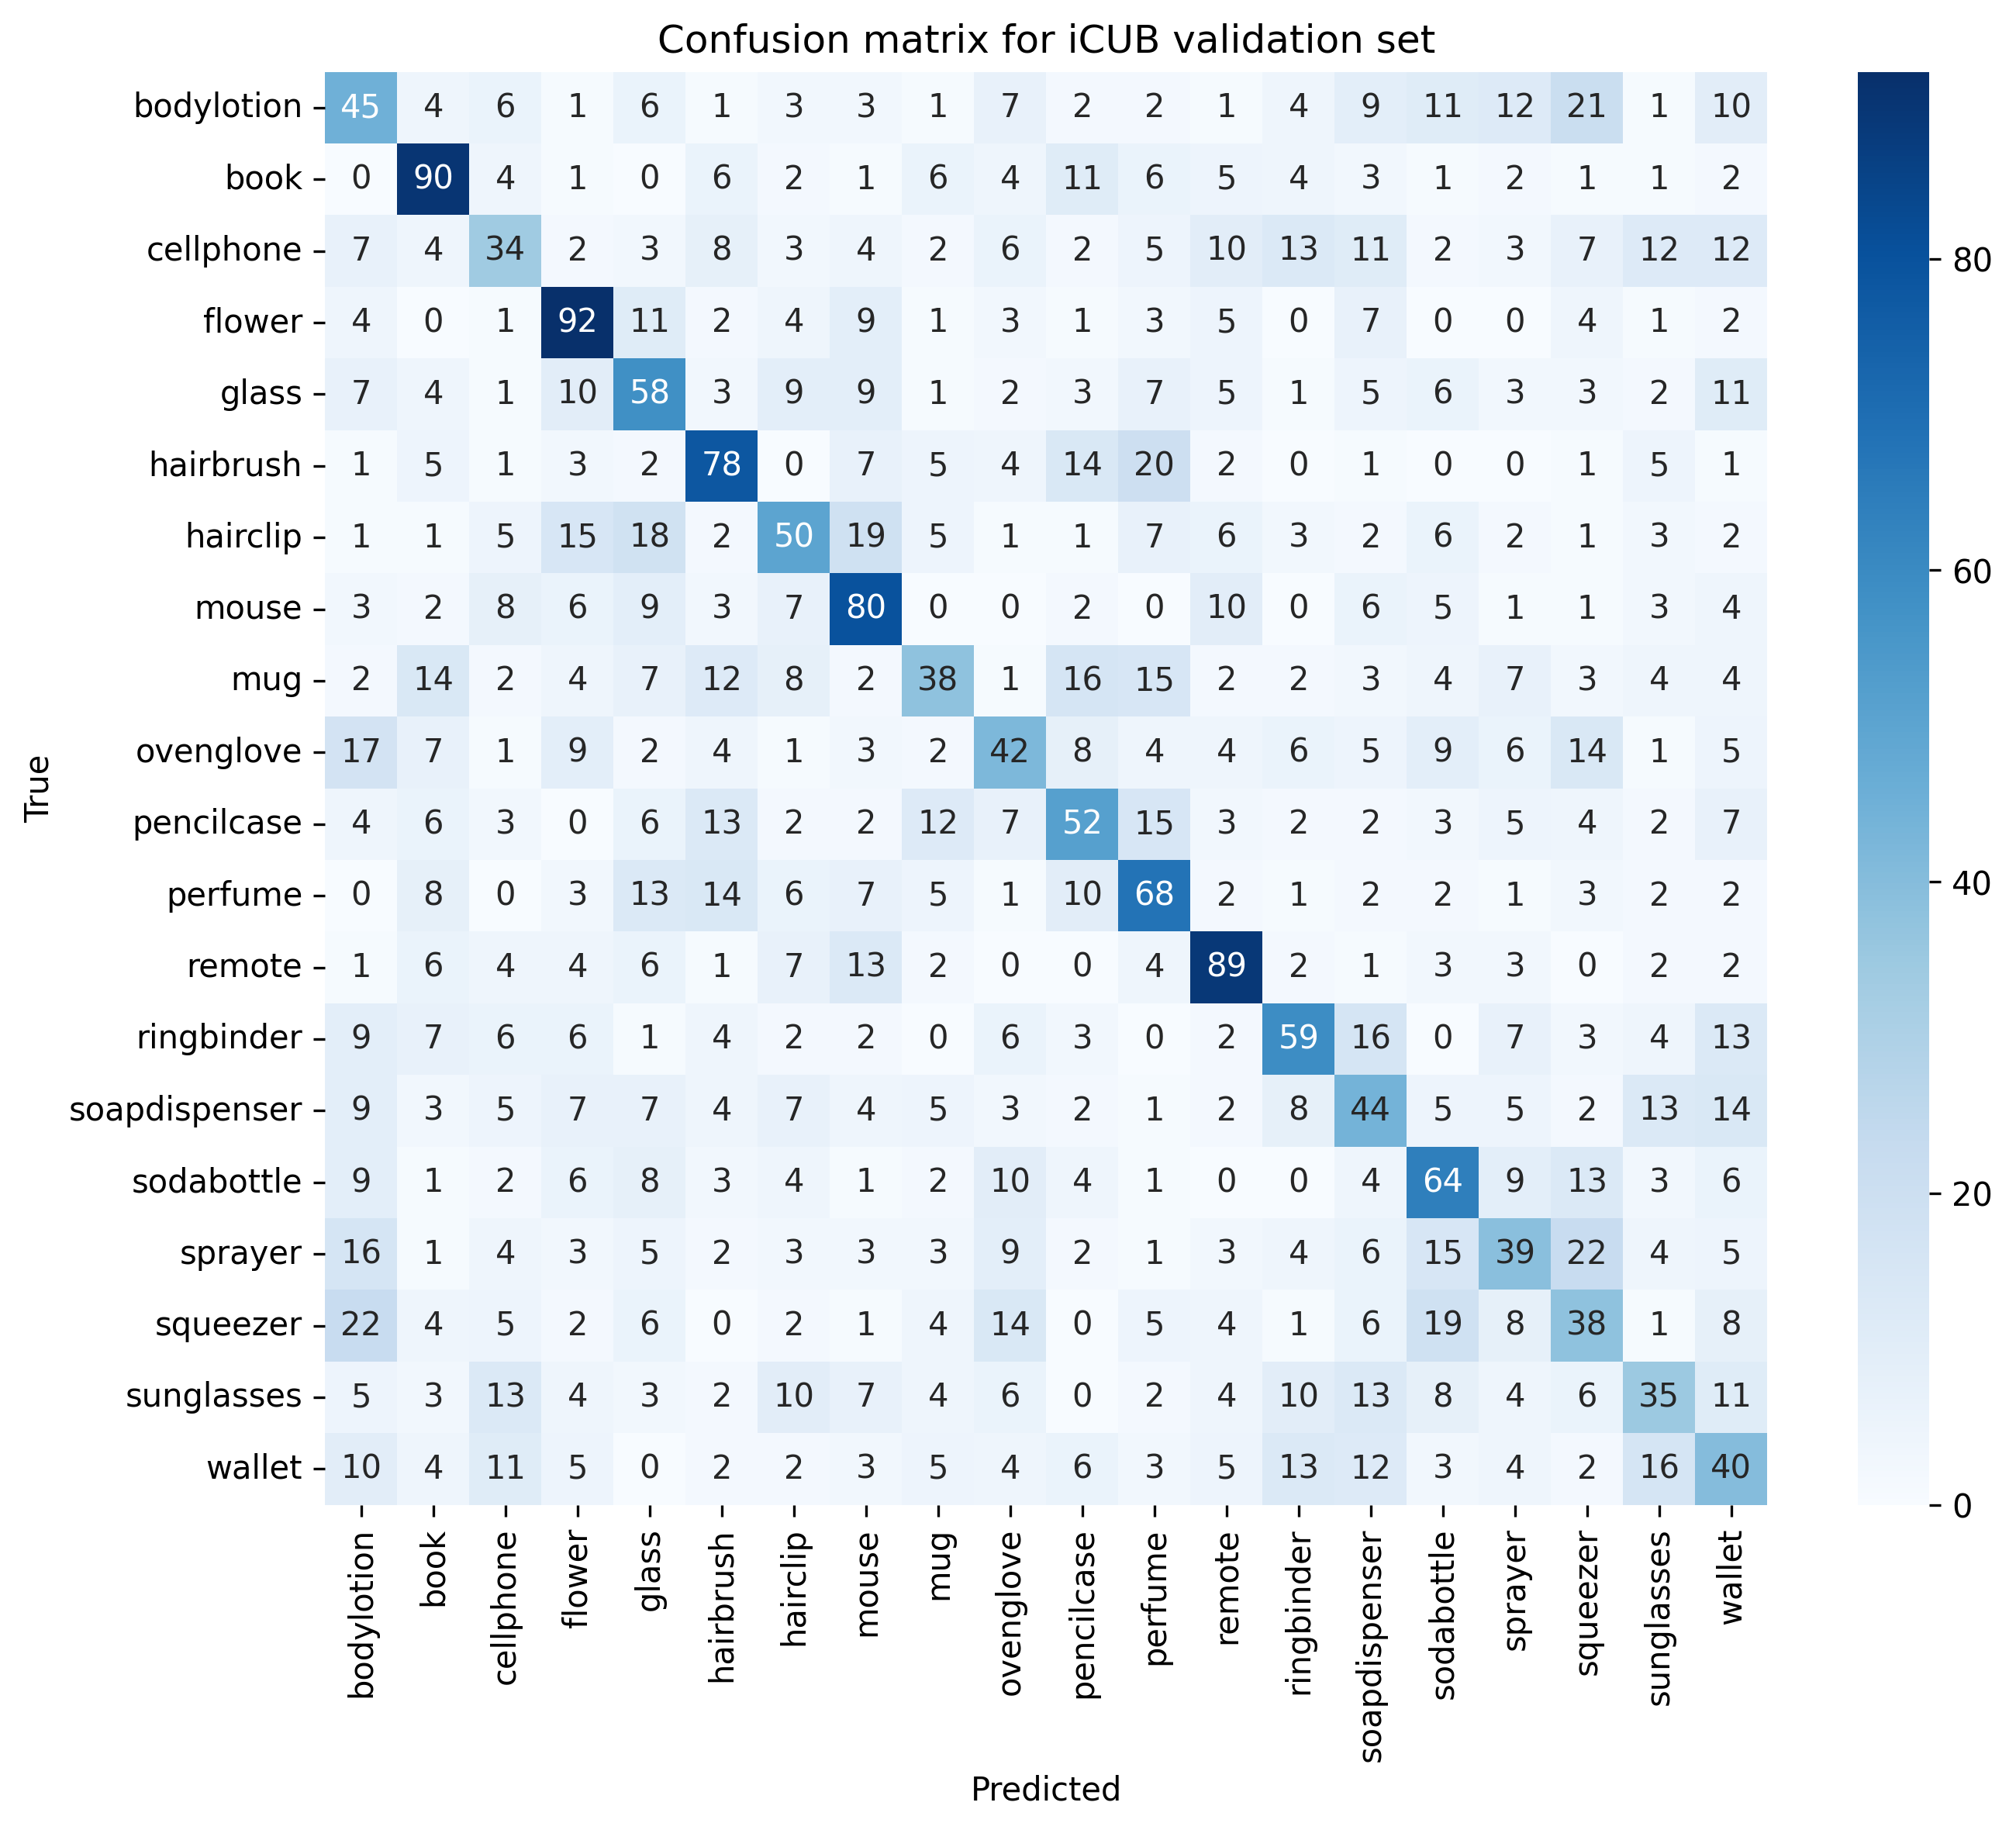

In [18]:
plot_confusion_matrix(y_eval, y_pred_eval, LABELS, 'Confusion matrix for iCUB validation set')